<a href="https://colab.research.google.com/github/kaicque/Projeto-Final-Bootcamp-DS/blob/main/Notebooks/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalação de pacotes

In [ ]:
!pip install lazypredict

  Using cached scikit_learn-0.23.1-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.0 requires scikit-learn>=0.24, but you have scikit-learn 0.23.1 which is incompatible.


In [ ]:
!pip install featurewiz

In [ ]:
!pip install yellowbrick

#Importação das bibliotecas usadas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve #,roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from featurewiz import featurewiz
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


# Criação de funções para facilitar o desenvolver do estudo

In [ ]:
## Definindo função para automatizar a verificação da acuracia e AUC (Area Under the Curve)
def  testa_acuracia(modelo, dados):

  # Definindo seed para o exercicio ser replicável
  np.random.seed(76538) 

  #Definindo parametro de dados
  y = dados["ICU"]
  x = dados.drop(["ICU"], axis=1)

  #Separando dados de treino e teste
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.15)
 
  #Rodando o modelo
  modelo.fit(x_train,y_train)

  #calculo dos scores
  predicao = modelo.predict(x_test)
  prob_predic = modelo.predict_proba(x_test)
  auc = roc_auc_score(y_test, prob_predic[:,1])

  #exibindo resultados
  print(f"A acurácia do Modelo é de: {(accuracy_score(y_test, predicao))*100 :.2f} %")
  print(f"A AUC é {auc :4f}")
  print("\nClassification Report do modelo:")
  print(classification_report(y_test,predicao))

In [ ]:
# Função para plotar a matriz de confusão de forma padronizada
def matriz_confusao(modelo,dados):

  # Definindo seed para o exercicio ser replicável
  np.random.seed(76538)

  #Definindo x e y
  x = dados.drop(['ICU'], axis=1) 
  y= dados['ICU']

  #Separando os dados em treino e teste
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.15)
 
  #Rodando o modelo 
  modelo.fit(x_train,y_train)

  #Predição
  predicao_dados = modelo.predict(x_test)

  #Plotando a matriz de confusão
  fig, ax = plt.subplots(figsize=(7,7))
  plot_confusion_matrix(modelo, x_test, y_test, normalize='true',ax=ax, display_labels=['Não precisa \n de internação','Precisa de \ninternação'], cmap=plt.cm.Greens)
  ax.set_title("Matriz de Confusão", fontsize=16, fontweight="heavy")
  ax.set_xlabel("Previsão", fontsize=18)
  ax.set_ylabel("Fato", fontsize=18)
  plt.grid(False)
  plt.show()

In [ ]:
## Definindo função para automatizar a cross validation e exibindo seu score médio do modelo
def  cross_validation(modelo, dados,n_splits,n_repeats):

  # Definindo seed para o exercicio ser replicável
  np.random.seed(76538)
  #Definindo parametro de dados  
  y = dados["ICU"]
  x = dados.drop(["ICU"], axis=1)

  # Função para embaralhar o dataset e evitar uma possível tendência
  dados = dados.sample(frac=1).reset_index(drop=True)

  #Repetição da separação dos dados de treino e teste 
  cv = RepeatedStratifiedKFold(n_splits = n_splits,n_repeats=n_repeats)
  #Rodando o modelo 
  resultados = cross_validate(modelo, x,y,cv=cv,scoring='roc_auc',return_train_score=True)
  
  #calculo dos scores  
  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])
  auc_std = np.std(resultados['test_score'])

  #exibição do resultado
  print(f"AUC médio é {auc_medio :4f} e o intervalo é {auc_medio-(2*auc_std) :4f} - {auc_medio+(2*auc_std) :4f}")

#Importação dos dados

In [ ]:
# Importando a planilha tratada, criando e visualizando o dataframe.
dados = pd.read_excel('https://github.com/kaicque/Projeto-Final-Bootcamp-DS/raw/main/Dados/Tratado/dados_tratado.xlsx')
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0,0,0,0,1,1,0,0,1,0.61,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.94,-1,-1.00,-1,0.18,-1,-0.87,-1,-0.74,-1,-0.95,-1,-0.89,-1,0.09,-1,-1,...,-1,0.36,-1,-0.54,-1,-0.52,-1,0.94,-1,0.35,-1,-0.03,-1,-1.00,-1,-0.99,-1,-0.83,-1,-0.84,-1,-0.99,-1,0.09,-0.23,-0.28,-0.59,-0.29,0.74,-0.50,-0.25,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0-2,1
1,2,0,0,0,0,0,0,0,0,0,0,0,1,0.61,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.94,-1,-1.00,-1,0.36,-1,-0.91,-1,-0.74,-1,-0.96,-1,-0.78,-1,0.14,-1,-1,...,-1,0.36,-1,-0.40,-1,-0.70,-1,0.94,-1,0.35,-1,0.09,-1,-1.00,-1,-0.99,-1,-0.85,-1,-0.84,-1,-0.98,-1,-0.49,-0.69,-0.05,-0.65,0.36,0.94,-0.71,-0.44,-0.55,-0.53,-0.60,-0.76,-1.00,-0.96,-0.75,0-2,1
2,3,0,3,1,0,0,0,0,0,0,0,1,1,-0.26,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.97,-1,-1.00,-1,0.33,-1,-0.97,-1,-0.19,-1,-0.32,-1,-0.89,-1,-0.20,-1,-1,...,-1,0.36,-1,-0.56,-1,-0.78,-1,0.94,-1,0.58,-1,0.20,-1,-0.99,-1,-0.96,-1,-0.85,-1,-0.94,-1,-0.98,-1,0.01,-0.37,-0.53,-0.46,-0.29,0.68,-0.36,-0.30,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0-2,0
3,4,0,0,0,0,0,0,0,0,0,0,0,1,0.61,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.94,-1,-1.00,-1,0.36,-1,-0.91,-1,-0.83,-1,-0.94,-1,-0.85,-1,0.36,-1,-1,...,-1,0.36,-1,-0.46,-1,-0.59,-1,0.94,-1,0.35,-1,0.14,-1,-1.00,-1,-0.99,-1,-0.85,-1,-0.90,-1,-1.00,-1,0.33,-0.15,0.16,-0.59,0.29,0.87,-0.57,-0.08,-1.00,-0.88,-0.92,-0.88,-0.95,-0.98,-0.96,0-2,0
4,5,0,0,0,0,0,0,0,0,0,0,0,1,0.61,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.94,-1,-1.00,-1,0.36,-1,-0.89,-1,-0.74,-1,-0.96,-1,-0.89,-1,0.29,-1,-1,...,-1,0.36,-1,-0.29,-1,-0.67,-1,0.94,-1,0.35,-1,0.09,-1,-1.00,-1,-0.99,-1,-0.85,-1,-0.88,-1,-1.00,-1,-0.04,-0.54,-0.54,-0.53,-0.20,0.82,-0.43,-0.25,-0.83,-0.75,-0.98,-1.00,-0.98,-0.98,-0.99,0-2,0


In [ ]:
#Excluindo a identificação do paciente e a janela, pois as mesmas foram tratadas para serem únicas
dados = dados.drop(['PATIENT_VISIT_IDENTIFIER','WINDOW'],axis=1)
dados.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU
0,1,5,0,0,0,0,0,1,1,0,0,1,0.61,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.94,-1,-1.00,-1,0.18,-1,-0.87,-1,-0.74,-1,-0.95,-1,-0.89,-1,0.09,-1,-1,-0.93,...,0.23,-1,0.36,-1,-0.54,-1,-0.52,-1,0.94,-1,0.35,-1,-0.03,-1,-1.00,-1,-0.99,-1,-0.83,-1,-0.84,-1,-0.99,-1,0.09,-0.23,-0.28,-0.59,-0.29,0.74,-0.50,-0.25,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1
1,0,0,0,0,0,0,0,0,0,0,0,1,0.61,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.94,-1,-1.00,-1,0.36,-1,-0.91,-1,-0.74,-1,-0.96,-1,-0.78,-1,0.14,-1,-1,-0.96,...,0.23,-1,0.36,-1,-0.40,-1,-0.70,-1,0.94,-1,0.35,-1,0.09,-1,-1.00,-1,-0.99,-1,-0.85,-1,-0.84,-1,-0.98,-1,-0.49,-0.69,-0.05,-0.65,0.36,0.94,-0.71,-0.44,-0.55,-0.53,-0.60,-0.76,-1.00,-0.96,-0.75,1
2,0,3,1,0,0,0,0,0,0,0,1,1,-0.26,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.97,-1,-1.00,-1,0.33,-1,-0.97,-1,-0.19,-1,-0.32,-1,-0.89,-1,-0.20,-1,-1,-0.96,...,0.23,-1,0.36,-1,-0.56,-1,-0.78,-1,0.94,-1,0.58,-1,0.20,-1,-0.99,-1,-0.96,-1,-0.85,-1,-0.94,-1,-0.98,-1,0.01,-0.37,-0.53,-0.46,-0.29,0.68,-0.36,-0.30,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0.61,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.94,-1,-1.00,-1,0.36,-1,-0.91,-1,-0.83,-1,-0.94,-1,-0.85,-1,0.36,-1,-1,-0.96,...,0.23,-1,0.36,-1,-0.46,-1,-0.59,-1,0.94,-1,0.35,-1,0.14,-1,-1.00,-1,-0.99,-1,-0.85,-1,-0.90,-1,-1.00,-1,0.33,-0.15,0.16,-0.59,0.29,0.87,-0.57,-0.08,-1.00,-0.88,-0.92,-0.88,-0.95,-0.98,-0.96,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0.61,-1,-1.00,-1,-1.00,-1,-0.32,-1,-0.32,-1,-0.94,-1,-1.00,-1,0.36,-1,-0.89,-1,-0.74,-1,-0.96,-1,-0.89,-1,0.29,-1,-1,-0.96,...,0.23,-1,0.36,-1,-0.29,-1,-0.67,-1,0.94,-1,0.35,-1,0.09,-1,-1.00,-1,-0.99,-1,-0.85,-1,-0.88,-1,-1.00,-1,-0.04,-0.54,-0.54,-0.53,-0.20,0.82,-0.43,-0.25,-0.83,-0.75,-0.98,-1.00,-0.98,-0.98,-0.99,0


#Inicio dos estudos

Para determinar que modelos seriam estudados no trabalho, usei o LazyClassifier para rankear os melhores modelos baseados na somatória dos scores

In [ ]:
#Nesse momento, estou usando o LazyClassifier para verificar os melhores modelos de acordo com os scores somados

# Definindo seed para o exercicio ser replicável
np.random.seed(76538)

#Definindo x e y
x = dados.drop(['ICU'], axis=1) 
y= dados['ICU']

#Separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.15)

# rodando o LazyClassifier
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(x_train, x_test, y_train, y_test) 

#Criando o totalizador dos scores
models['Totalizadora'] = models['Accuracy']+models['Balanced Accuracy']+models['ROC AUC']+models['F1 Score']

#Ordenando pelo total dos scores
models = models.sort_values(by='Totalizadora',ascending=False)

#Exibindo os 5 melhores modelos vistos
models.head()

100%|██████████| 29/29 [00:02<00:00, 14.15it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken,Totalizadora
Model,,,,,,
NearestCentroid,0.75,0.75,0.75,0.75,0.03,3.01
PassiveAggressiveClassifier,0.74,0.73,0.73,0.73,0.03,2.94
NuSVC,0.72,0.72,0.72,0.72,0.06,2.88
ExtraTreesClassifier,0.72,0.72,0.72,0.72,0.19,2.86
RandomForestClassifier,0.70,0.70,0.69,0.70,0.28,2.79


# Definição dos modelos:
Com o resumo dos melhores modelos sugeridos, optei pelos seguintes modelos para o estudo: 
 
  1) XGBClassifier

  2) LogisticRegression

  3) ExtraTreesClassifier

---------------------


Para testar e avaliar cada modelo, seguirei o seguinte roteiro:

*   Acuracia, AUC e Classification report
*   Matriz de confusão do modelo
*   Cross Validation
*   Grafico da Curva ROC

# Inicio dos testes

## XGBClassifier





In [ ]:
# Criação do modelo
modelo_xgb = XGBClassifier()

In [ ]:
# rodando a acurácia do modelo XGB
testa_acuracia(modelo_xgb,dados)

A acurácia do Modelo é de: 60.38 %
A AUC é 0.677143

Classification Report do modelo:
              precision    recall  f1-score   support

           0       0.65      0.54      0.59        28
           1       0.57      0.68      0.62        25

    accuracy                           0.60        53
   macro avg       0.61      0.61      0.60        53
weighted avg       0.61      0.60      0.60        53



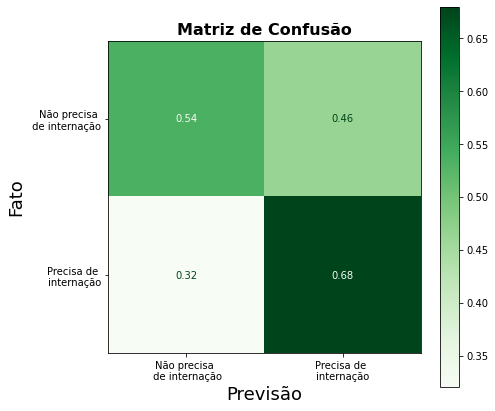

In [ ]:
# rodando matriz de confusão pro modelo XGB
matriz_confusao(modelo_xgb,dados)

In [ ]:
# rodando o cross validation pro modelo XGB
cross_validation(modelo_xgb,dados,5,10)

AUC médio é 0.783362 e o intervalo é 0.682252 - 0.884473


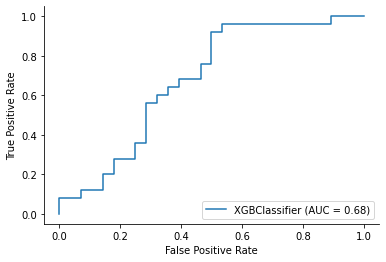

In [ ]:
# rodando a curva ROC do modelo XGB
plot_roc_curve(modelo_xgb, x_test, y_test)
sns.despine()
plt.show()

## Logistic Regression

In [ ]:
#Criando o modelo de regressão
modelo_regressao = LogisticRegression()

In [ ]:
# Rodando a acurácia do modelo de regressão
testa_acuracia(modelo_regressao,dados)

A acurácia do Modelo é de: 84.91 %
A AUC é 0.865714

Classification Report do modelo:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.81      0.88      0.85        25

    accuracy                           0.85        53
   macro avg       0.85      0.85      0.85        53
weighted avg       0.85      0.85      0.85        53



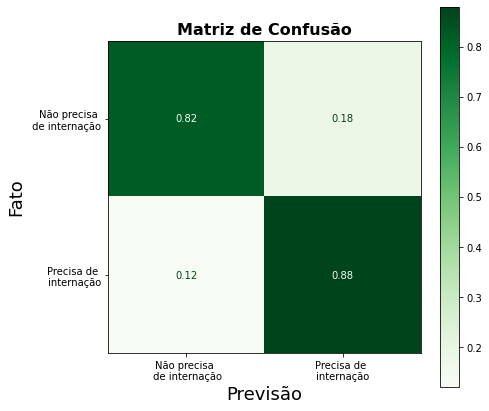

In [ ]:
# Rodando a matriz de confusão do modelo de regressão
matriz_confusao(modelo_regressao,dados)

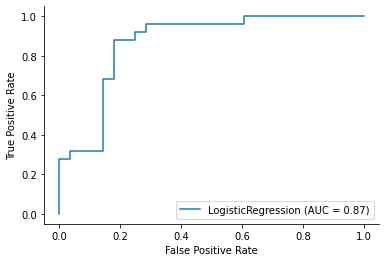

In [ ]:
# Rodando a curva ROC do modelo de regressão
plot_roc_curve(modelo_regressao, x_test, y_test)
sns.despine()
plt.show()

In [ ]:
# Rodando a cross validation do modelo de regressão
cross_validation(modelo_regressao,dados,5,10)

AUC médio é 0.767637 e o intervalo é 0.663334 - 0.871940


## ExtraTreesClassifier

In [ ]:
# Criando o modelo Extra Trees Classifier
modelo_exc = ExtraTreesClassifier()

In [ ]:
# Rodando a acurácia do modelo Extra Trees Classifier
testa_acuracia(modelo_exc,dados)

A acurácia do Modelo é de: 73.58 %
A AUC é 0.839286

Classification Report do modelo:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        28
           1       0.72      0.72      0.72        25

    accuracy                           0.74        53
   macro avg       0.73      0.73      0.73        53
weighted avg       0.74      0.74      0.74        53



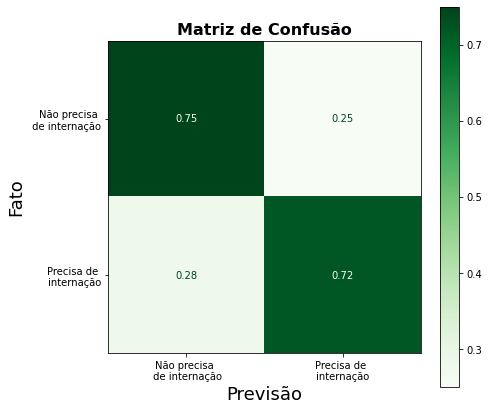

In [ ]:
# Rodando a matriz de confusão do modelo Extra Trees Classifier
matriz_confusao(modelo_exc,dados)

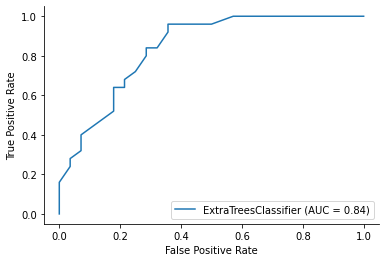

In [ ]:
plot_roc_curve(modelo_exc, x_test, y_test)
sns.despine()
plt.show()

In [ ]:
# Rodando a curva ROC do modelo Extra Trees Classifier
cross_validation(modelo_exc,dados,5,10)

AUC médio é 0.785964 e o intervalo é 0.672433 - 0.899494


#Conclusão prévia:

Com os modelos estudados conseguimos os seguintes resultados:

Scores:


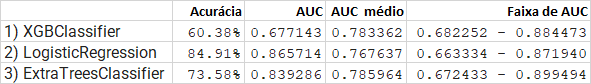

Classification Reports:


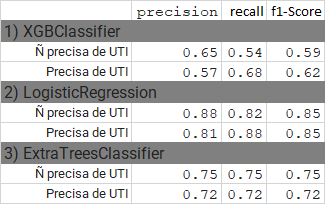

Com os resultados, observamos que o modelo LogisticRegression, apesar de ter uma faixa de AUC levemente menor que dos outros modelos, a precisão e o recall dele são os maiores. Considerando esse conjunto ele é o que pode trazer maior acertividade e confiança.

# Aplicando o FeatureWiz

Neste momento do trabalho, usaremos o Featurewiz para determinar as melhores features e verificar se houve melhora nos resultados

Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Loading train data...
Shape of your Data Set loaded: (352, 98)
Loading test data...
    Filename is an empty string or file not able to be loaded
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    97 Predictors classified...
        36 variable(s) will be ignored since they are ID or low-information variables
GPU active on this device
    Running XGBoost using GPU parameters
Removing 36 columns from further processing since ID or low information variables
    columns removed: ['ALBUMIN_DIFF', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_DIFF', 'BLAST_DIFF', 'CALCIUM_DIFF', 'CREATININ_DIFF', 'FFA_DIFF', 'GGT_DIFF', 'GLUCOSE_DIFF', 'HEMATOCRITE_DIFF', 'HEMOGLOBIN_DIFF', 'INR_DIFF', 'LACTATE_DIFF', 'LEUKOCYTES_DIFF', 'LINFOCITOS_DIFF', 'NEUTROP

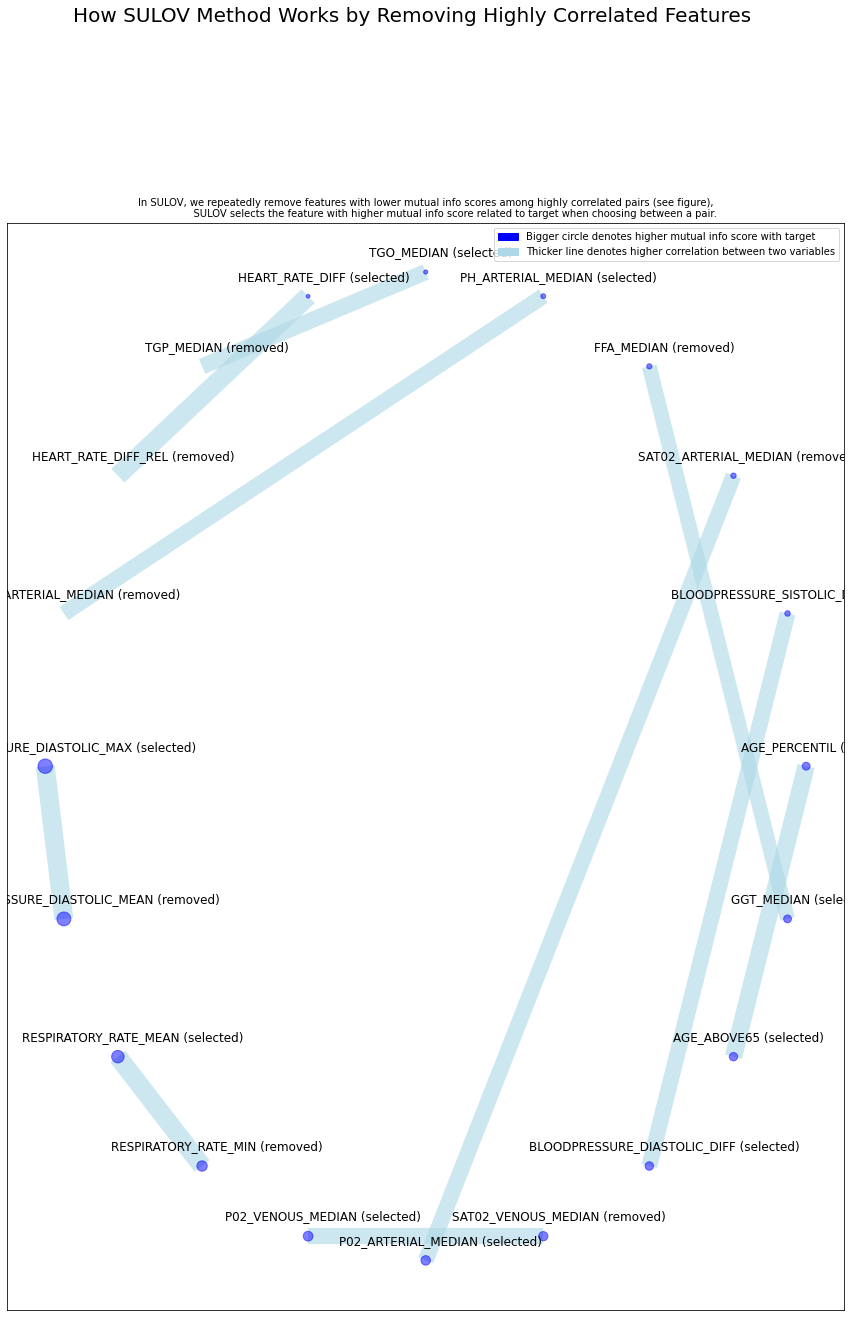

    Adding 0 categorical variables to reduced numeric variables  of 51
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 51 
    Finding Important Features using Boosted Trees algorithm...
        using 51 variables...
        using 41 variables...
        using 31 variables...
        using 21 variables...
        using 11 variables...
        using 1 variables...
Selected 14 important features from your dataset
    Time taken (in seconds) = 1
Returning list of 14 important features and dataframe.


In [ ]:
# Rodando o Featurewiz
features_wiz = featurewiz(dados, target='ICU', corr_limit=0.70, verbose=2)

In [ ]:
# Gravando as colunas que o FeatureWizz considerou ótimas para filtrar no data frame
list_colunas = pd.DataFrame(columns=features_wiz[0])
list_colunas['ICU'] = ""

Criando novo dataset com as features selecionadas

In [ ]:
# Criando o novo data frame com apenas as features selecionadas pelo FeatureWizz
dados_features = dados[list_colunas.columns]

In [ ]:
# Olhando os dados do novo data frame
dados_features.head()

,PCR_MEDIAN,HTN,LACTATE_MEDIAN,P02_VENOUS_MEDIAN,UREA_MEDIAN,RESPIRATORY_RATE_MEAN,SODIUM_MEDIAN,GLUCOSE_MEDIAN,AGE_ABOVE65,INR_MEDIAN,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_DIASTOLIC_MAX,GGT_MEDIAN,HEART_RATE_DIFF,ICU
0,-0.88,0,1.00,-0.70,-0.84,-0.59,-0.03,-0.89,1,-0.93,-1.00,-0.25,-0.95,-1.00,1
1,-0.94,0,1.00,-0.70,-0.84,-0.65,0.09,-0.78,0,-0.96,-0.55,-0.44,-0.96,-0.60,1
2,-0.50,0,-0.83,-0.63,-0.94,-0.46,0.20,-0.89,0,-0.96,-1.00,-0.30,-0.32,-1.00,0
3,-0.99,0,1.00,-0.70,-0.90,-0.59,0.14,-0.85,0,-0.96,-1.00,-0.08,-0.94,-0.92,0
4,-1.00,0,1.00,-0.70,-0.88,-0.53,0.09,-0.89,0,-0.96,-0.83,-0.25,-0.96,-0.98,0


## XGBClassifier com featurewiz

In [ ]:
# Rodando a acurácia do modelo XGB com feature wizz
testa_acuracia(modelo_xgb,dados_features)

A acurácia do Modelo é de: 73.58 %
A AUC é 0.832857

Classification Report do modelo:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        28
           1       0.69      0.80      0.74        25

    accuracy                           0.74        53
   macro avg       0.74      0.74      0.74        53
weighted avg       0.74      0.74      0.74        53



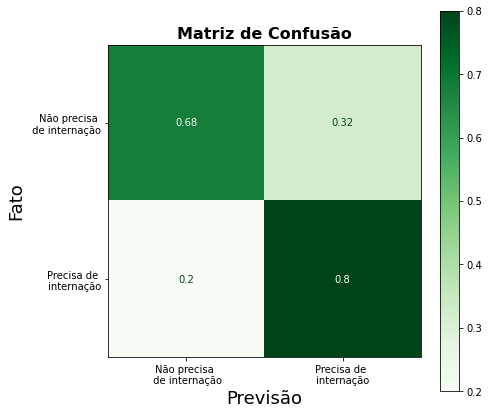

In [ ]:
# Rodando a matriz de confusão do modelo XGB com feature wizz
matriz_confusao(modelo_xgb,dados_features)

In [ ]:
# Rodando a cross validation do modelo XGB com feature wizz
cross_validation(modelo_xgb,dados_features,5,10)

AUC médio é 0.775283 e o intervalo é 0.686404 - 0.864161


## LogisticRegression com featurewiz

In [ ]:
# Rodando a acurácia do modelo LogisticRegression com feature wizz
testa_acuracia(modelo_regressao,dados_features)

A acurácia do Modelo é de: 73.58 %
A AUC é 0.862857

Classification Report do modelo:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.70      0.76      0.73        25

    accuracy                           0.74        53
   macro avg       0.74      0.74      0.74        53
weighted avg       0.74      0.74      0.74        53



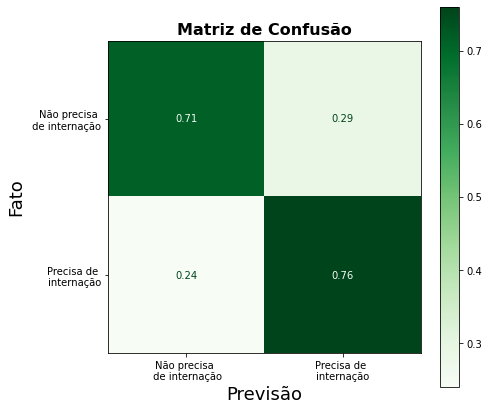

In [ ]:
# Rodando a matriz de confusão do modelo LogisticRegression com feature wizz
matriz_confusao(modelo_regressao,dados_features)

In [ ]:
# Rodando a cross validation do modelo LogisticRegression com feature wizz
cross_validation(modelo_regressao,dados_features,5,10)

AUC médio é 0.779386 e o intervalo é 0.672919 - 0.885853


## ExtraTreesClassifier com featurewiz

In [ ]:
# Rodando a acurácia do modelo ExtraTreesClassifier com feature wizz
testa_acuracia(modelo_exc,dados_features)

A acurácia do Modelo é de: 81.13 %
A AUC é 0.836429

Classification Report do modelo:
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.78      0.84      0.81        25

    accuracy                           0.81        53
   macro avg       0.81      0.81      0.81        53
weighted avg       0.81      0.81      0.81        53



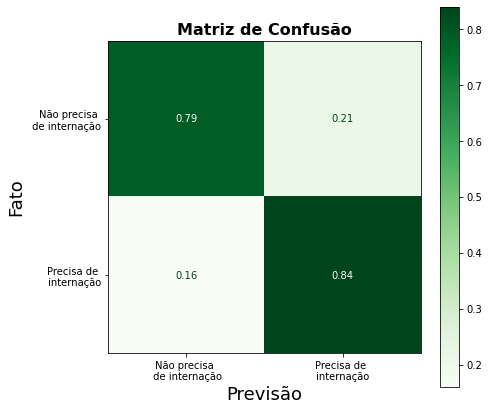

In [ ]:
# Rodando a matriz de confusão do modelo ExtraTreesClassifier com feature wizz
matriz_confusao(modelo_exc,dados_features)

In [ ]:
# Rodando a cross validation do modelo ExtraTreesClassifier com feature wizz
cross_validation(modelo_exc,dados_features,5,10)

AUC médio é 0.784627 e o intervalo é 0.673419 - 0.895835


# Conclusão:

Scores: 

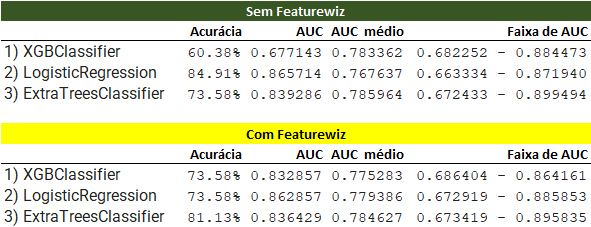

Classification Reports:

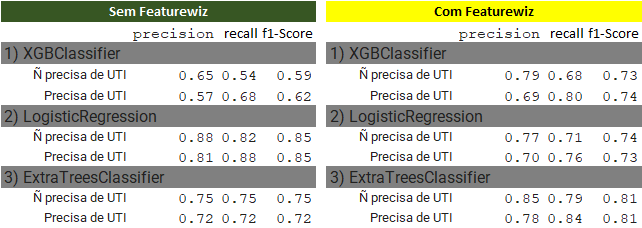


A aplicação do Featurewiz para determinar as features importantes com o intuito de melhorar nosso score, demonstra uma equalização nos scores dos modelos e melhora significativa no modelo **XGBClassifier** e no **ExtreesClassifier**. Mas os resultados do **LogisticRegression** parece ser mais constante.



Vale a observação, que o dataset disponibilizado pelo Sírio-Libanês, vinha com 230 features, entre elas classificações de doenças, exames de sangue e exames respiratórios. E dentre essas colunas eram 46 categorias de exames unicos que se separavão entre medidas de máximo, minimo, mediana e desvio. 

Com o a redução de features feita pelo featurewiz, restaram somente 14 no dataset final. Isso é um sinal de que o modelo pode estar enviesado. 

Para concluir nosso as analises feitas com suas devidas limitações técnicas, o modelo **LogisticRegression** se mostrou mais aderente ao estudo proposto.
Mostrando melhores scores e classificações.
Como opções de melhorias seria voltar o data frame original e melhorar hiperparammetros do modelo ao inves de tirar feature com o featurewiz

# Para futuros estudos:



*   É indiscutível a possíbilidade de melhoria do resultado com a inclusão de outras janelas de tempo em que o paciente está no hospital. Sem dispensar uma procura por otimização de hiperparametros do modelo.
*   Também é possível buscar melhoria dos resultados se manter pelo menos uma feature de cada categoria de exame, pois assim poderemos ver outros tipos de padrões de resultado de exame que indicam uma piora do paciente com COVID.

